# Google colab commands

In [ ]:
!git clone https://github.com/Francesco9932/financial-sentiment-analysis

In [ ]:
%cd financial-sentiment-analysis/

In [ ]:
!unzip glove.6B.200d.txt.zip

# Data preprocessing and test-train split

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.models import load_model

In [2]:
df = pd.read_csv('all-data.csv', encoding="latin-1",
                 names=['sentiment', 'news headline'])
df.head()

,sentiment,news headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


<AxesSubplot:>

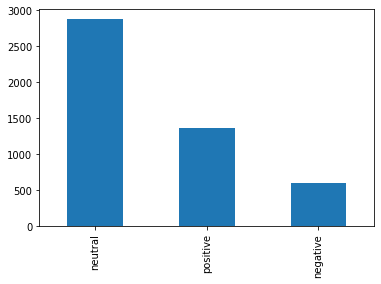

In [3]:
df['sentiment'].value_counts().plot(kind='bar')

In [4]:
print("original shape: ", df.shape)
df = df.drop_duplicates()
print("after drop duplicates shape: ", df.shape)
dd_dn = df.dropna()
print("after drop null shape: ", df.shape)

original shape:  (4846, 2)
after drop duplicates shape:  (4840, 2)
after drop null shape:  (4840, 2)


In [5]:
df['news headline'][1]

'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'

In [5]:
X = df['news headline'].to_list()
y = df['sentiment'].to_list()

In [1]:
import torch.nn as nn
from transformers import AutoModel
class PosModel(nn.Module):
    def __init__(self):
        super(PosModel, self).__init__()
        
        self.base_model = AutoModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(768, 3) # output features from bert is 768 and 2 is ur number of labels
        
    def forward(self, input_ids, attn_mask):
        outputs = self.base_model(input_ids, attention_mask=attn_mask)
        # You write you new head here
        outputs = self.dropout(outputs[0])
        outputs = self.linear(outputs)
        
        return outputs

model = PosModel()
# model.to('cuda')

Downloading:  47%|████▋     | 199M/420M [05:59<09:55, 389kB/s]   

In [1]:
from torchsummary import summary

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

Downloading: 100%|██████████| 533/533 [00:00<00:00, 383kB/s]
Downloading: 100%|██████████| 419M/419M [00:38<00:00, 11.4MB/s] 
Downloading: 100%|██████████| 221k/221k [00:00<00:00, 8.48MB/s]


In [7]:
labels = {0:'neutral', 1:'positive',2:'negative'}

In [8]:
sent_val = list()
for x in X:
    inputs = tokenizer(x, return_tensors="pt", padding=True)
    outputs = finbert(**inputs)[0]
   
    val = labels[np.argmax(outputs.detach().numpy())]
    print(x, '----', val)
    print('#######################################################')    
    sent_val.append(val)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing . ---- neutral
#######################################################
Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said . ---- neutral
#######################################################
The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported . ---- neutral
#######################################################
With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability . ---- positive
########################

In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y, sent_val))

0.7923553719008265


In [6]:
import re
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/francesco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def headline_to_words(headline):
    ''' Convert headline text into a sequence of words '''
    
    # convert to lowercase
    text = headline.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal headline ->", df['news headline'][0])
print("\nProcessed headline ->", headline_to_words(df['news headline'][0]))


Original headline -> According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

Processed headline -> ['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']


In [10]:
X = list(map(headline_to_words, df['news headline']))

In [ ]:
X

In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
le.fit(df['sentiment'])
print(le.classes_)
Y = le.transform(df['sentiment'])

['negative' 'neutral' 'positive']


In [12]:
print(X[0])
print(Y[0])

['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']
1


In [13]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print("Vocab length:", len(word_index) + 1)

max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
print("Maximum sequence length:", max_seq_length)
sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

Vocab length: 7714
Maximum sequence length: 69


In [14]:
train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, Y, train_size=0.7, shuffle=True, random_state=1)

In [15]:
print('Train Set ->', train_sequences.shape, y_train.shape)
print('Test Set ->', test_sequences.shape, y_test.shape)

Train Set -> (3388, 69) (3388,)
Test Set -> (1452, 69) (1452,)


# Global Vectors for Word Representation (GloVe)

In [45]:
vocab_size = 7714
embedding_size = 200

embeddings_index = {}

with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


embeddings_matrix = np.zeros((vocab_size+1, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [46]:
print(embeddings_matrix.shape)

(7715, 200)


# CNN1d Model

In [49]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size+1,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1],
                              weights=[embeddings_matrix])(inputs)

convs = []
filter_sizes = [2,3,4,5,6]

for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(x)
    l_pool = tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)

l_merge = tf.keras.layers.concatenate(convs, axis=1)
x = tf.keras.layers.Dropout(0.1)(l_merge)  
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 69)]         0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 69, 200)      1543000     ['input_10[0][0]']               
                                                                                                  
 conv1d_35 (Conv1D)             (None, 68, 200)      80200       ['embedding_9[0][0]']            
                                                                                                  
 conv1d_36 (Conv1D)             (None, 67, 200)      120200      ['embedding_9[0][0]']            
                                                                                            

In [52]:
epochs = 100
batch_size=32

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_cnn1d.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100
95/96 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9941
Epoch 00001: val_accuracy improved from -inf to 0.72566, saving model to ./best_model/best_model_cnn1d.h5
96/96 [==============================] - 5s 55ms/step - loss: 0.0210 - accuracy: 0.9938 - val_loss: 1.6720 - val_accuracy: 0.7257
Epoch 2/100
95/96 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9891
Epoch 00002: val_accuracy did not improve from 0.72566
96/96 [==============================] - 5s 55ms/step - loss: 0.0500 - accuracy: 0.9892 - val_loss: 1.1717 - val_accuracy: 0.7227
Epoch 3/100
95/96 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9954
Epoch 00003: val_accuracy improved from 0.72566 to 0.72861, saving model to ./best_model/best_model_cnn1d.h5
96/96 [==============================] - 6s 59ms/step - loss: 0.0215 - accuracy: 0.9951 - val_loss: 1.3490 - val_accuracy: 0.7286
Epoch 4/100
95/96 [============================>.] - ET

In [53]:
saved_model = load_model('./best_model/best_model_cnn1d.h5')

results = saved_model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

Test Losss: 1.29452
Test accuracy: 73.76033%


# LSTM Model

In [54]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1])(inputs)
x = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [55]:
epochs = 100
batch_size=32

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_lstm.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100
96/96 [==============================] - ETA: 0s - loss: 0.8275 - accuracy: 0.6494
Epoch 00001: val_accuracy improved from -inf to 0.69027, saving model to ./best_model/best_model_lstm.h5
96/96 [==============================] - 10s 94ms/step - loss: 0.8275 - accuracy: 0.6494 - val_loss: 0.7129 - val_accuracy: 0.6903
Epoch 2/100
96/96 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8222
Epoch 00002: val_accuracy improved from 0.69027 to 0.72271, saving model to ./best_model/best_model_lstm.h5
96/96 [==============================] - 9s 89ms/step - loss: 0.4397 - accuracy: 0.8222 - val_loss: 0.6900 - val_accuracy: 0.7227
Epoch 3/100
96/96 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9364
Epoch 00003: val_accuracy did not improve from 0.72271
96/96 [==============================] - 8s 86ms/step - loss: 0.1736 - accuracy: 0.9364 - val_loss: 0.9803 - val_accuracy: 0.6991
Epoch 4/100
96/96 [==============================] - ETA

In [57]:
saved_model = load_model('./best_model/best_model_lstm.h5')

results = saved_model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

Test Losss: 1.37549
Test accuracy: 72.52066%
